# Flare Analysis from Lightcurves

In [2]:
from astropy.io import fits

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
%matplotlib inline

## 1) Exploring LC Files

In [4]:
lc_23sep = fits.open('Data/ch2_xsm_20210923_v1_level2.lc')
lc_23sep.info()

Filename: Data/ch2_xsm_20210923_v1_level2.lc
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   ()      
  1  RATE          1 BinTableHDU     64   84280R x 4C   [D, E, E, E]   


In [5]:
header1_23sep = lc_23sep[0].header
header1_23sep

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
MISSION = 'CHANDRAYAAN-2'      / Name of mission/satellite                      
TELESCOP= 'CH-2_ORBITER'       / Name of mission/satellite                      
INSTRUME= 'CH2_XSM '           / Name of Instrument/detector                    
ORIGIN  = 'PRLPOC  '           / Source of FITS file                            
CREATOR = 'xsmgenlc '          / Creator of file                                
FILENAME= 'ch2_xsm_20210923_v1_level2.lc' / Name of file                        
CONTENT = 'Light curve'     

In [6]:
header2_23sep = lc_23sep[1].header
header2_23sep

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   20 / width of table in bytes                        
NAXIS2  =                84280 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    4 / number of fields in each row                   
TTYPE1  = 'TIME    '           / label for field   1                            
TFORM1  = 'D       '           / data format of field: 8-byte DOUBLE            
TTYPE2  = 'RATE    '           / label for field   2                            
TFORM2  = 'E       '           / data format of field: 4-byte REAL              
TTYPE3  = 'ERROR   '        

The 2nd header file contains count rate, and hence is the more important file.

In [7]:
lc_24sep = fits.open('Data/ch2_xsm_20210924_v1_level2.lc')
lc_28sep = fits.open('Data/ch2_xsm_20210928_v1_level2.lc')
lc_27sep = fits.open('Data/ch2_xsm_20210927_v1_level2.lc')
lc_29sep = fits.open('Data/ch2_xsm_20210929_v1_level2.lc')

## 2) Lightcurves

In [8]:
data_23sep = lc_23sep[1].data
data_23sep, data_23sep.shape

(FITS_rec([(1.49126401e+08, 494.83276, 22.244837, 1.),
           (1.49126402e+08, 518.2688 , 22.765518, 1.),
           (1.49126403e+08, 504.4697 , 22.460403, 1.), ...,
           (1.49212797e+08, 376.00684, 19.390896, 1.),
           (1.49212798e+08, 374.12167, 19.342226, 1.),
           (1.49212799e+08, 401.34076, 20.033491, 1.)],
          dtype=(numpy.record, [('TIME', '>f8'), ('RATE', '>f4'), ('ERROR', '>f4'), ('FRACEXP', '>f4')])),
 (84280,))

In [9]:
data_23sep['RATE']

array([494.83276, 518.2688 , 504.4697 , ..., 376.00684, 374.12167,
       401.34076], dtype=float32)

In [10]:
lc = [lc_23sep, lc_24sep, lc_27sep, lc_28sep, lc_29sep];
headers = [l[1].header for l in lc];
data = [l[1].data for l in lc]

Data is stored as a numpy record with 84280 entries, and each entry contains 4 fields:
1) Time
2) Count Rate
3) Error in count rate
4) FracExp


### Visual Identification of flares

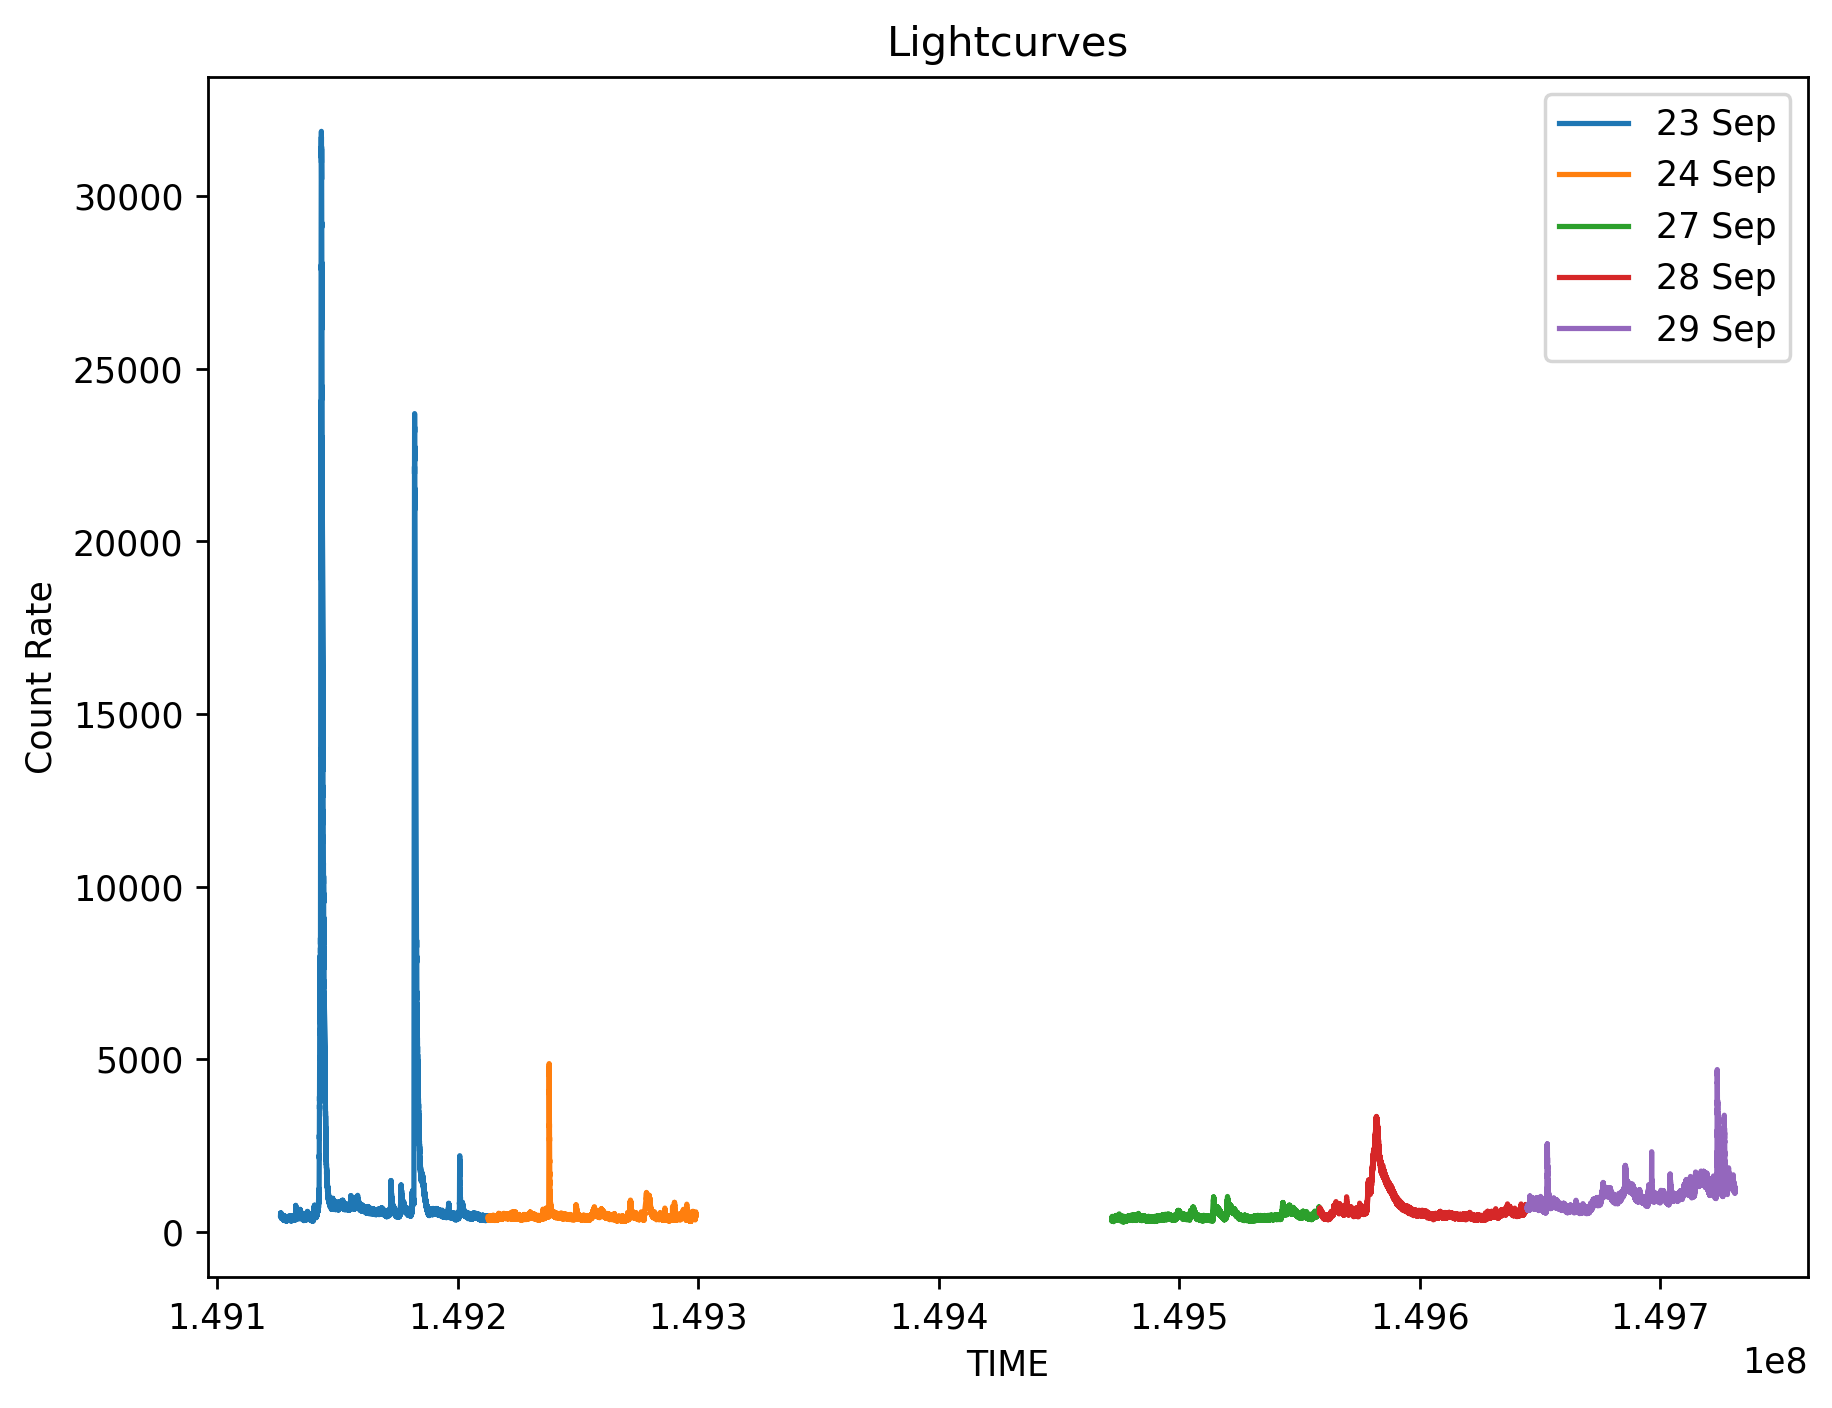

In [11]:
fig = plt.figure(dpi=250)
dates = ['23 Sep', '24 Sep', '27 Sep', '28 Sep', '29 Sep']
ax = fig.add_axes([0, 0, 1, 1])
for i in range(5):
    ax.plot(data[i]['TIME'], data[i]['RATE'])
    ax.set_title('Lightcurves')
    ax.set_xlabel('TIME')
    ax.set_ylabel('Count Rate')
ax.legend(dates);

Peculiarity in the time axis is that we did not take measurements on 25th and 26th September, and hence that data is missing.

We have to identify the flares in the lightcurve visually, and that can be done using the interactive image in `jupyter notebook`, made possible by the `%matplotlib notebook` command.

Visually, I have inferred the following to be the start and corresponding end times of flares from the given lightcurves.
I have used the zoom function in the interactive image in `jupyter notebook` to get these values.

In [12]:
start = np.array([1.4914128e08, 1.4917621e08, 149200497, 149237824, 149577815, 149652482, 149685302, 149696331, 149723348])
stop = np.array([1.4914759e08, 1.4918800e08, 149201799, 149239296, 149598094, 149654437, 149688092, 149697148, 149727993])

Wherever in the graph I saw inordinate increase in the count rate of the lightcurves, I zoomed in and recorded the start and end points of the increase. At some places there were small increases in the count rate quite close to a flare, and I have not considered them to be flares, as they could be small ejections before the actual flare.

### Calculation of Means, Peaks, Slopes

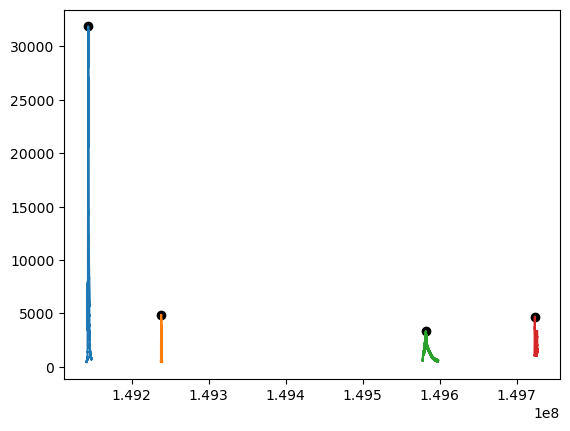

In [13]:
means = []
peaks = []
rise_slopes = []
fall_slopes = []

# will choose 4 flares to find these characteristics for, each from a different day
chosen_flares = [1, 4, 5, 9]

#the start and end times of these chosen flares
flare_start = [start[i-1] for i in chosen_flares]
flare_end = [stop[i-1] for i in chosen_flares]

# which day it is
i = 0
for start_time, stop_time in zip(flare_start, flare_end):
    if (i==2):
        # no flare on the day 27th September
        i=3
    #Filtering the times such that they lie in the flare occurence period
    bool_arr = (data[i]['TIME'] >= start_time) & (data[i]['TIME'] <= stop_time)
    flare_time = data[i]['TIME'][bool_arr]
    flare_rates = data[i]['RATE'][bool_arr]
    # Plotting the flares only, just for verification
    plt.plot(flare_time, flare_rates)

    # Calculating mean, peak, slopes
    means.append(flare_rates.mean())
    peak_val = flare_rates.max()
    peaks.append(peak_val)
    max_time = flare_time[flare_rates == peak_val]
    rise_slopes.append((peak_val - flare_rates[0])/(max_time - start_time)[0])
    fall_slopes.append((peak_val - flare_rates[-1])/(stop_time - max_time)[0])

    # Verifying the peaks
    plt.scatter(max_time, peak_val, c='black')
    # Moving to the next day
    i+=1


In [14]:

print(f'The means in the given flares are ')
print(means)
print(f'The peaks in the given flares are ')
print(peaks)
print(f'The average slopes of rise in the given flares are ')
print(rise_slopes)
print(f'The average slopes of fall in the given flares are ')
print(fall_slopes)

The means in the given flares are 
[6097.838, 1463.0272, 1277.6661, 1949.3021]
The peaks in the given flares are 
[31883.889, 4872.3403, 3341.9844, 4699.799]
The average slopes of rise in the given flares are 
[14.9343439206224, 16.30366098401912, 0.6408051325946612, 8.609139281952856]
The average slopes of fall in the given flares are 
[7.400899210488301, 3.5918755596871654, 0.17049830606400415, 0.7824120491767391]


### Mean Background Rate

In [15]:
complete_time = data[0]['TIME']
complete_rate = data[0]['RATE']
for i in range(1, 5):
    complete_time = np.concatenate((complete_time, data[i]['TIME']))
    complete_rate = np.concatenate((complete_rate, data[i]['RATE']))
flares = ((complete_time > start[0]) & (complete_time < stop[0]))
for start_time, stop_time in zip(start, stop):
    flares = flares | ((complete_time > start_time) & (complete_time < stop_time))

background_times = complete_time[np.logical_not(flares)]
background_rates = complete_rate[np.logical_not(flares)]


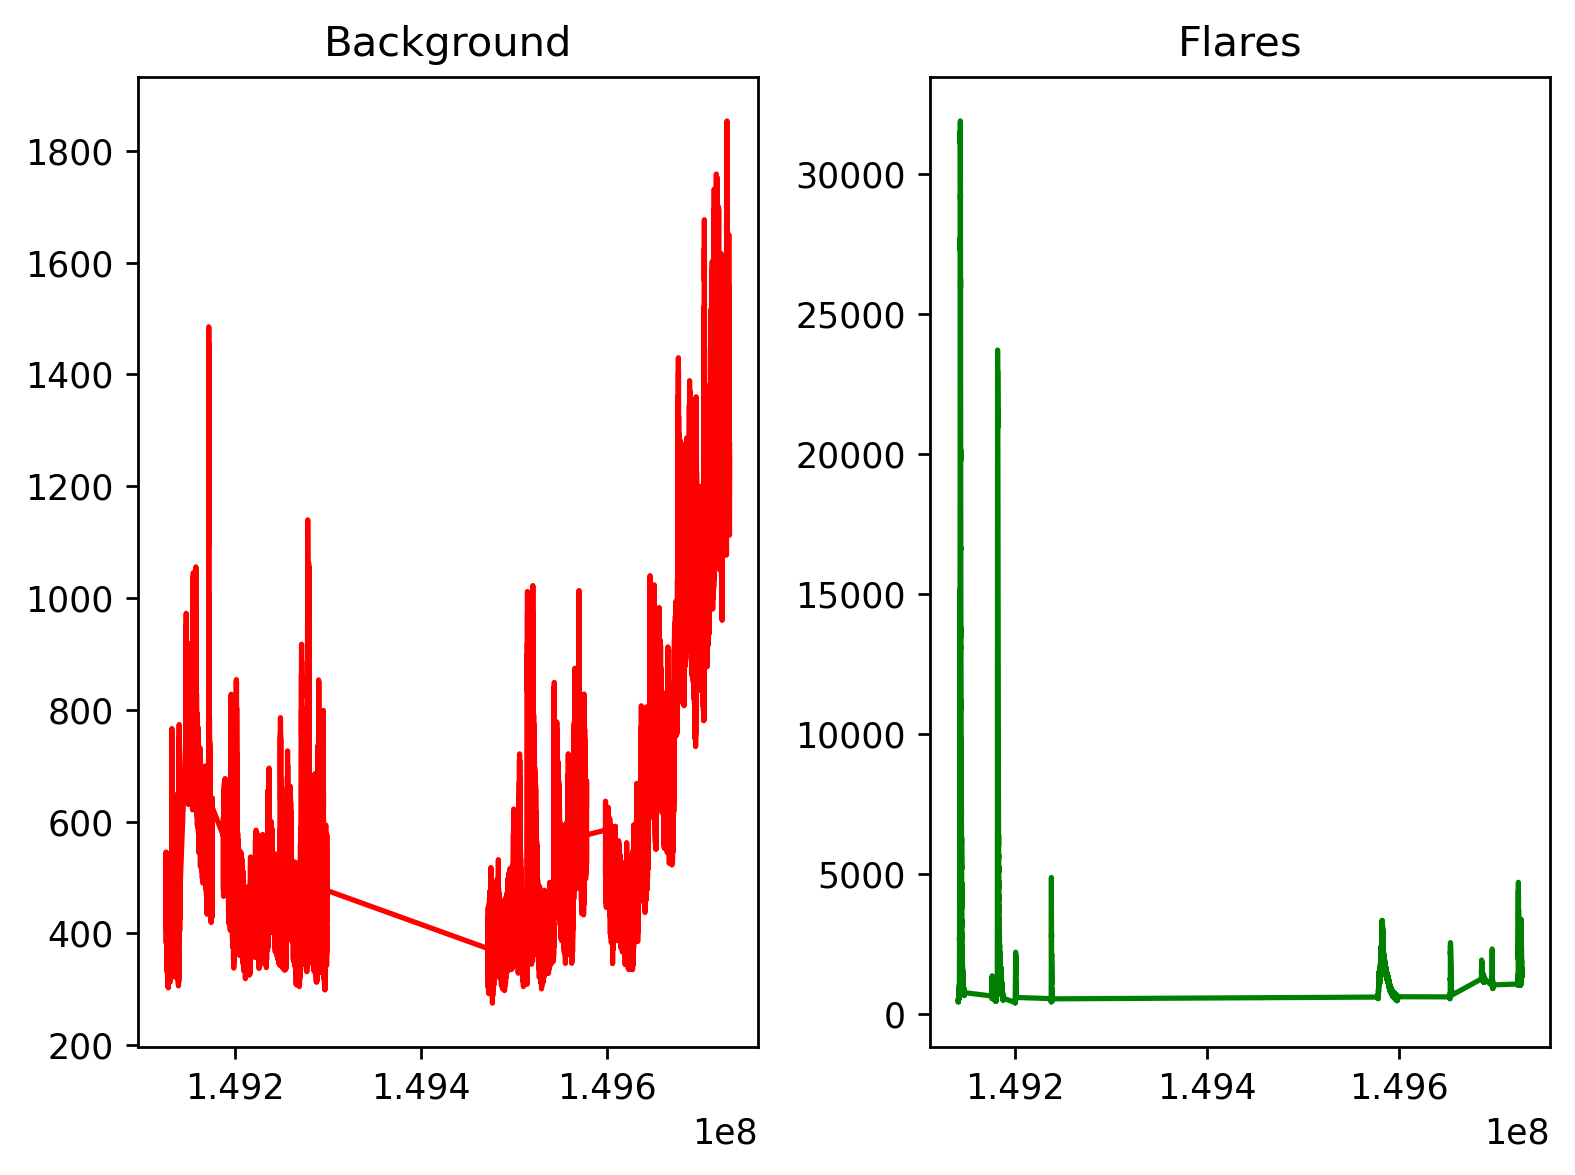

In [16]:
#Verifying our background lightcurve points
Curve, axes = plt.subplots(1, 2, dpi=250)

axes[0].plot(background_times, background_rates, 'r');
axes[0].set_title('Background')
axes[1].plot(complete_time[flares], complete_rate[flares], 'g')
axes[1].set_title('Flares')
Curve.tight_layout()

In [17]:
mean_background_rate = background_rates.mean()
flare_mean_rate = complete_rate[flares].mean()
print(f'The mean background rate is {mean_background_rate}')
print(f'In Contrast, the mean flare rate is {flare_mean_rate}')

The mean background rate is 590.7055053710938
In Contrast, the mean flare rate is 2066.176025390625


# N-Sigma

## 1) Smoothing the Lightcurve

In [18]:
from astropy.convolution import convolve, Box1DKernel

In [42]:
intervals = [(data[i]['TIME'][-1] - data[i]['TIME'][0])/50 for i in range(5)]
intervals

[1727.96, 1724.94, 1727.96, 1727.98, 1727.96]

In [57]:
intervals = [(data[i]['TIME'][-1] - data[i]['TIME'][0]) for i in range(5)]
def smooth_lightcurves(interval):
    return [convolve(data[i]['RATE'], Box1DKernel(intervals[i]/interval)) for i in range(5)]

In [64]:
smooth_lightcurves_80 = smooth_lightcurves(80)
smooth_lightcurves_40 = smooth_lightcurves(40)

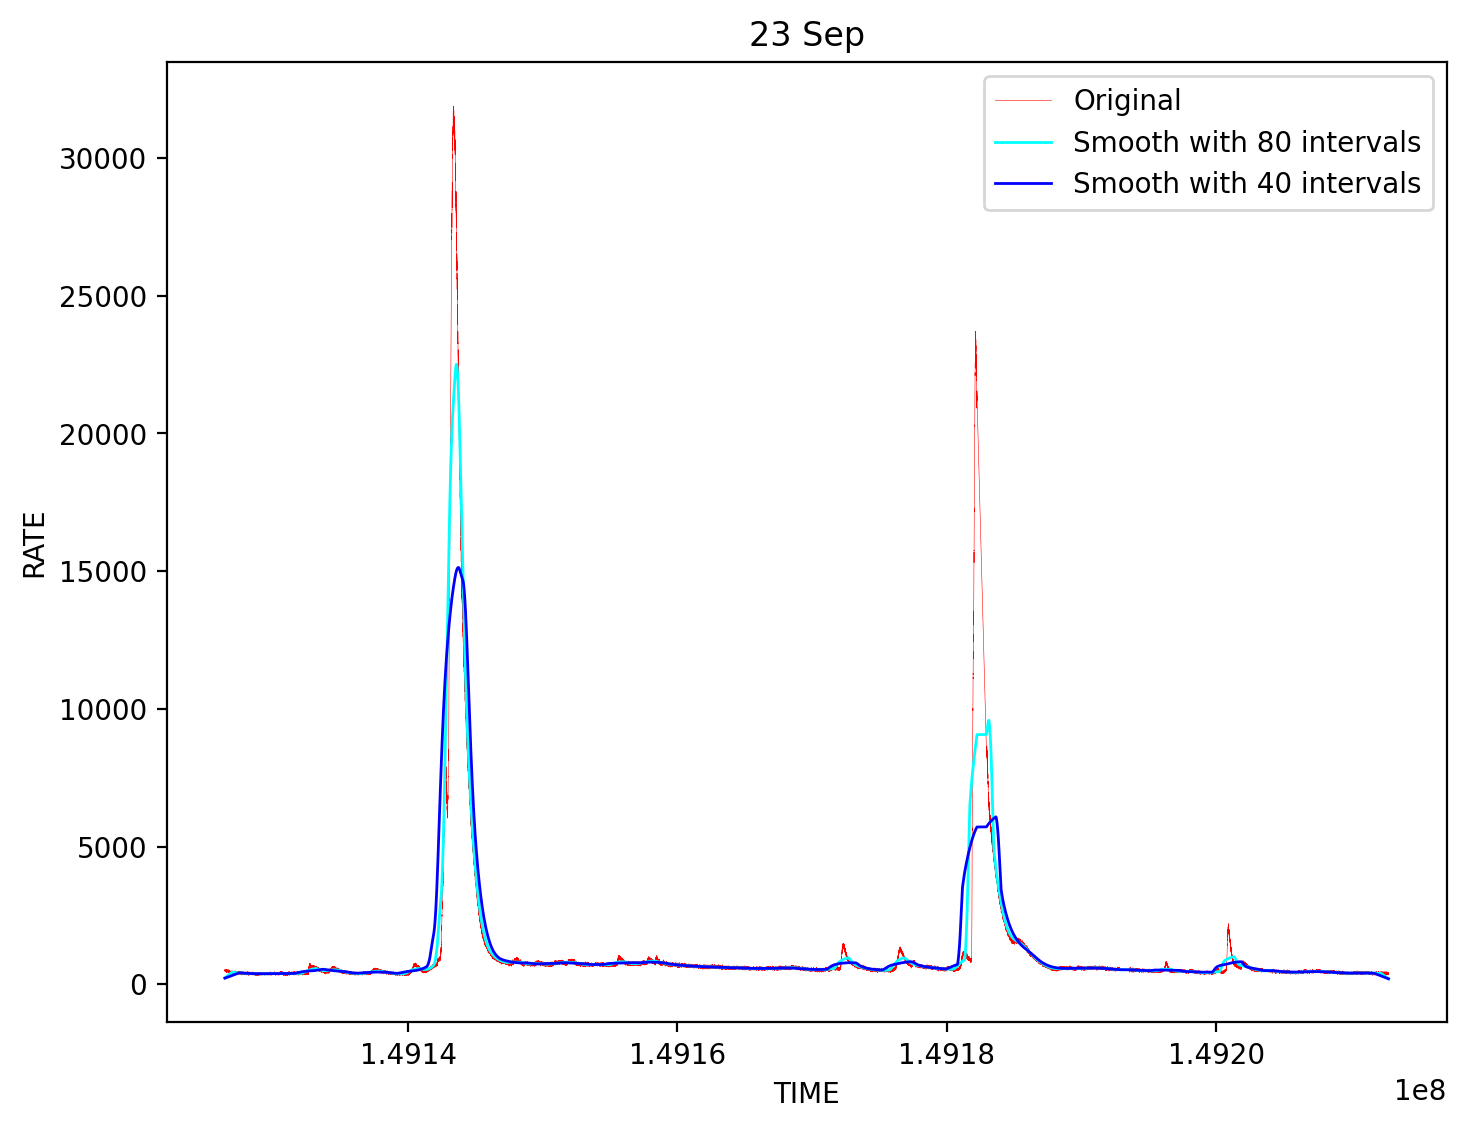

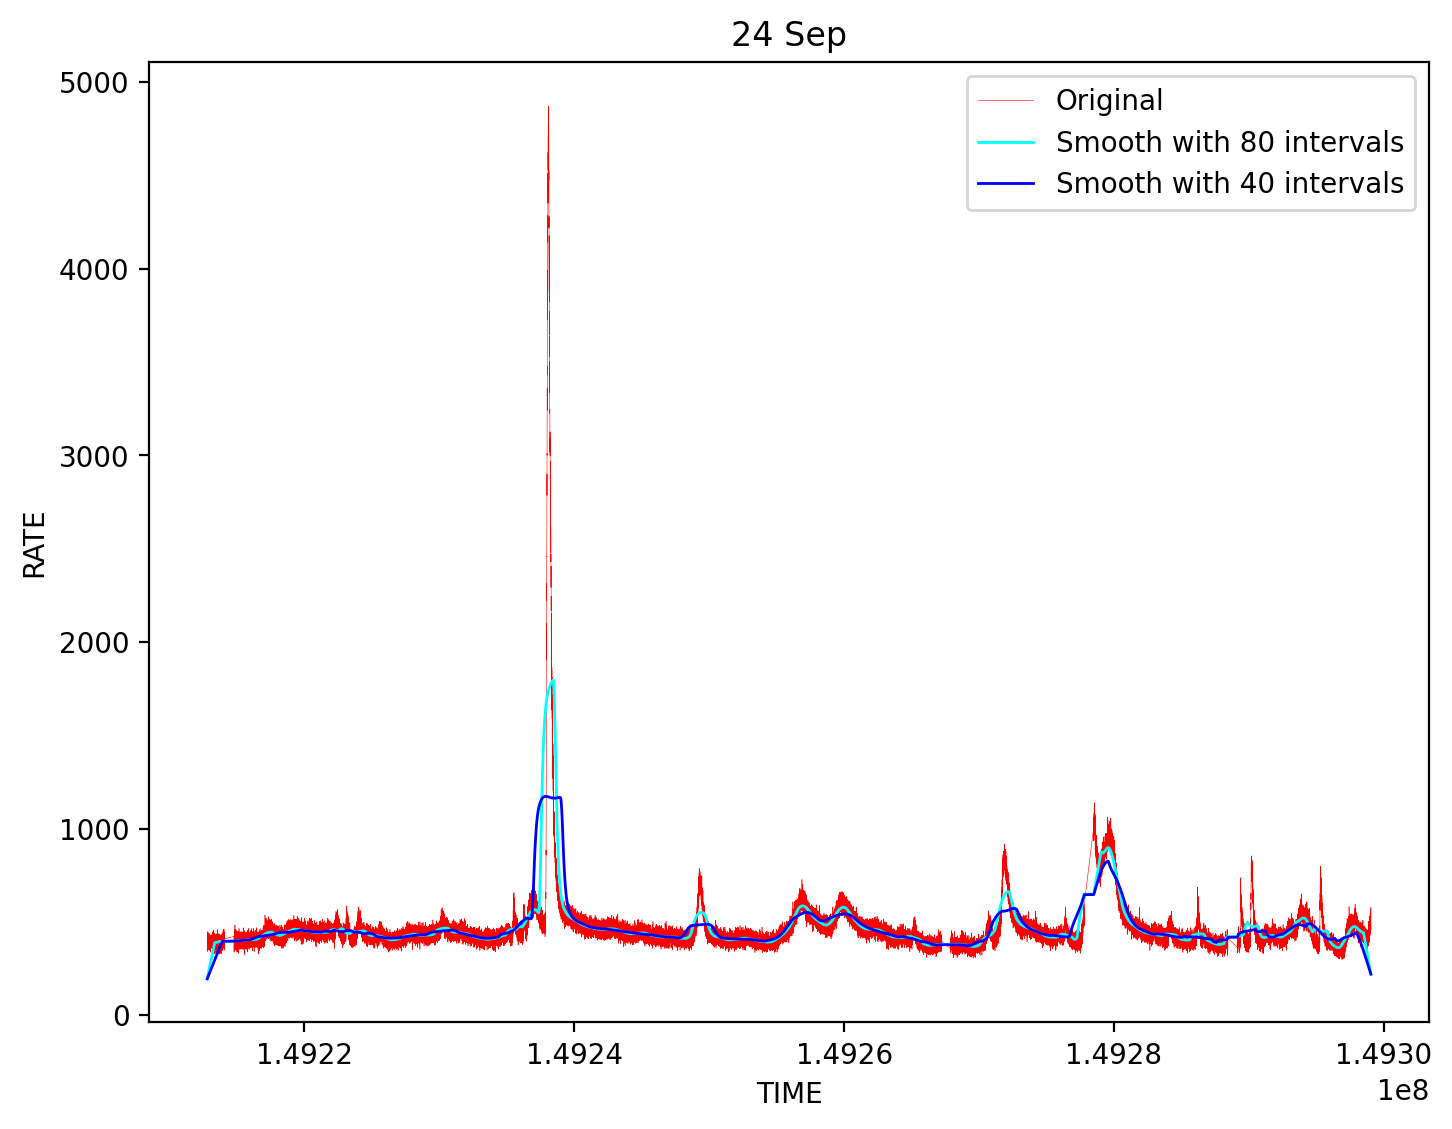

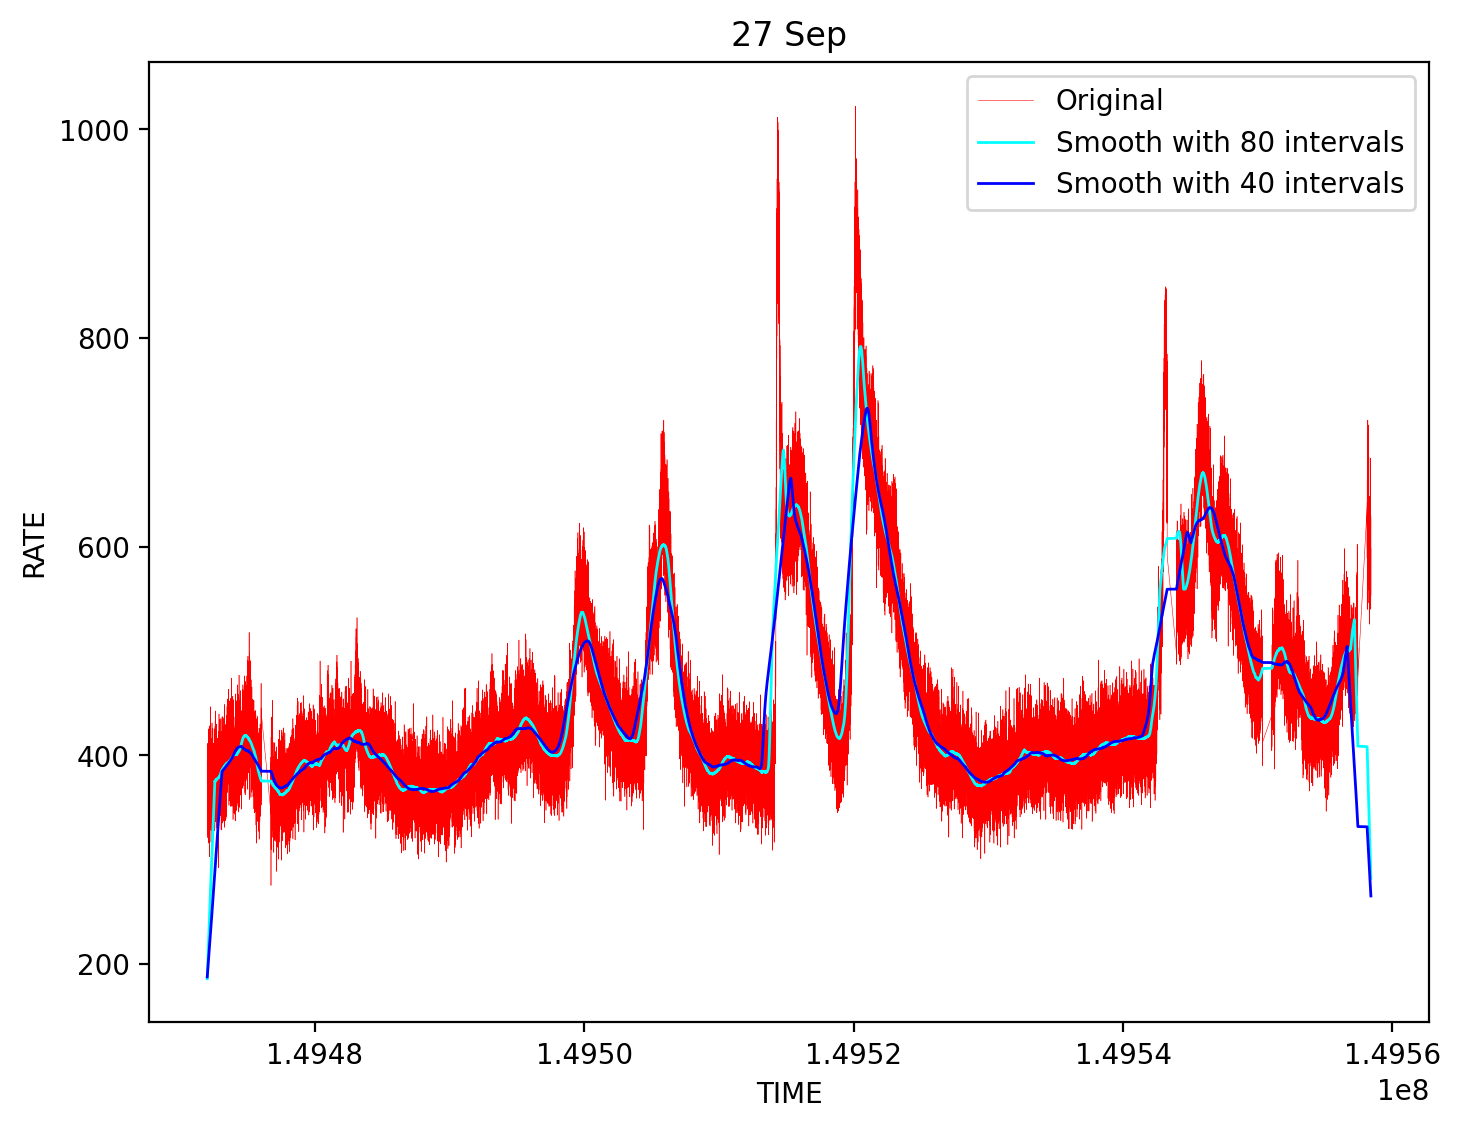

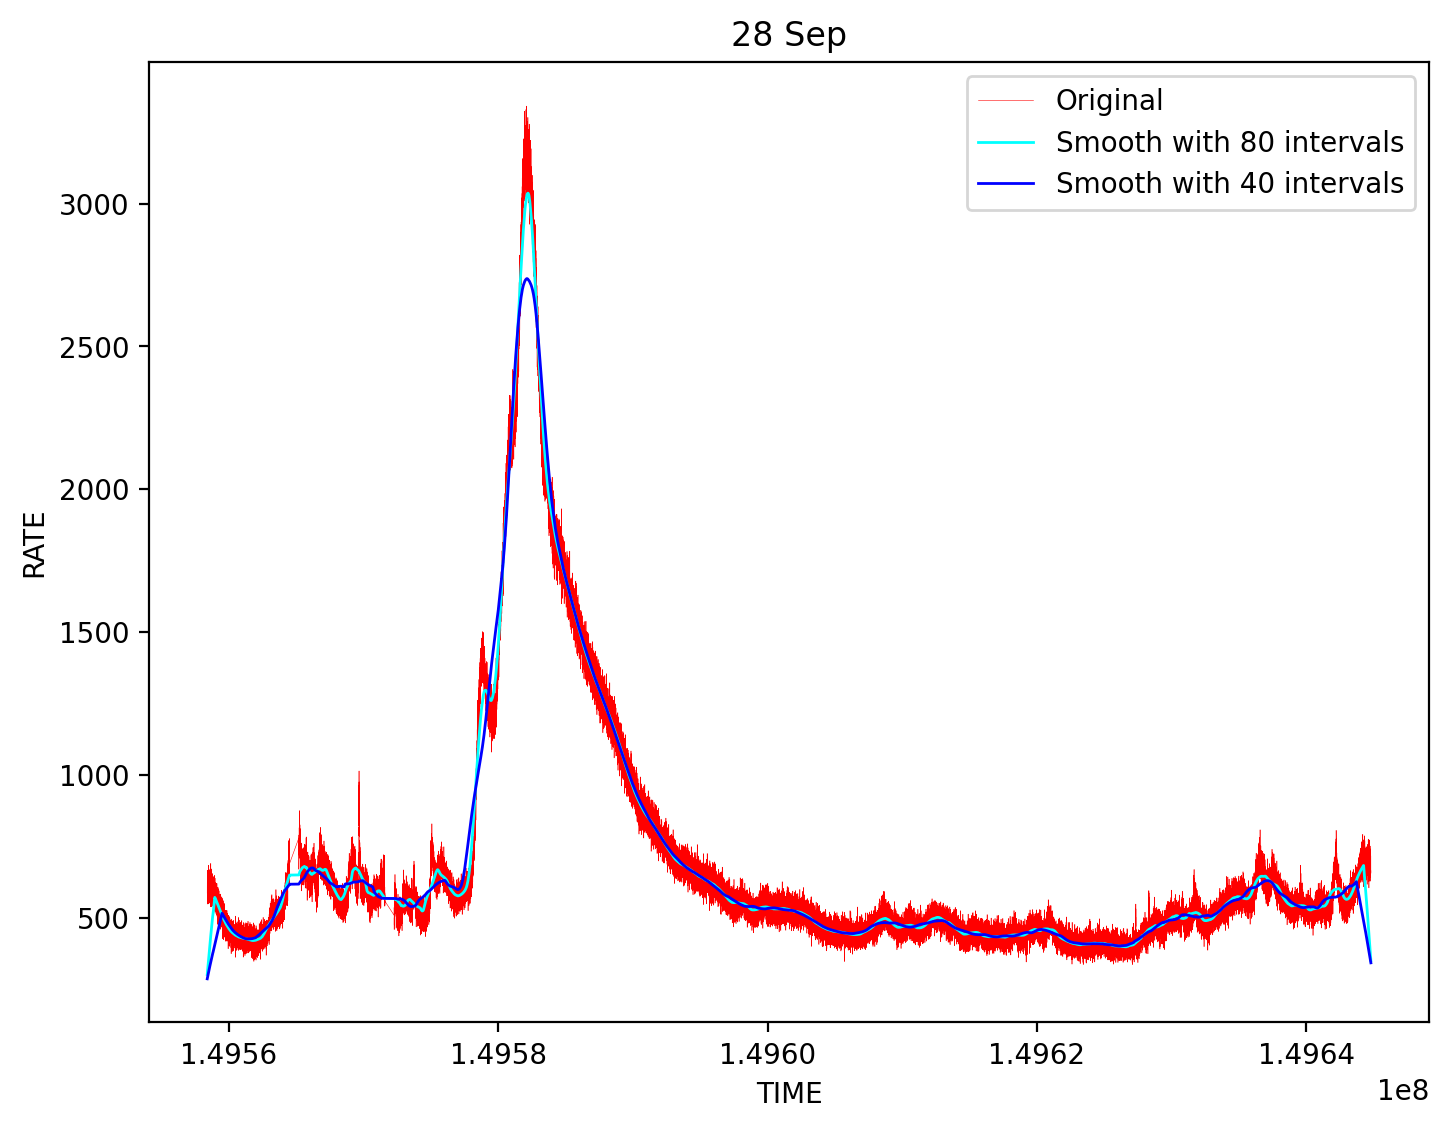

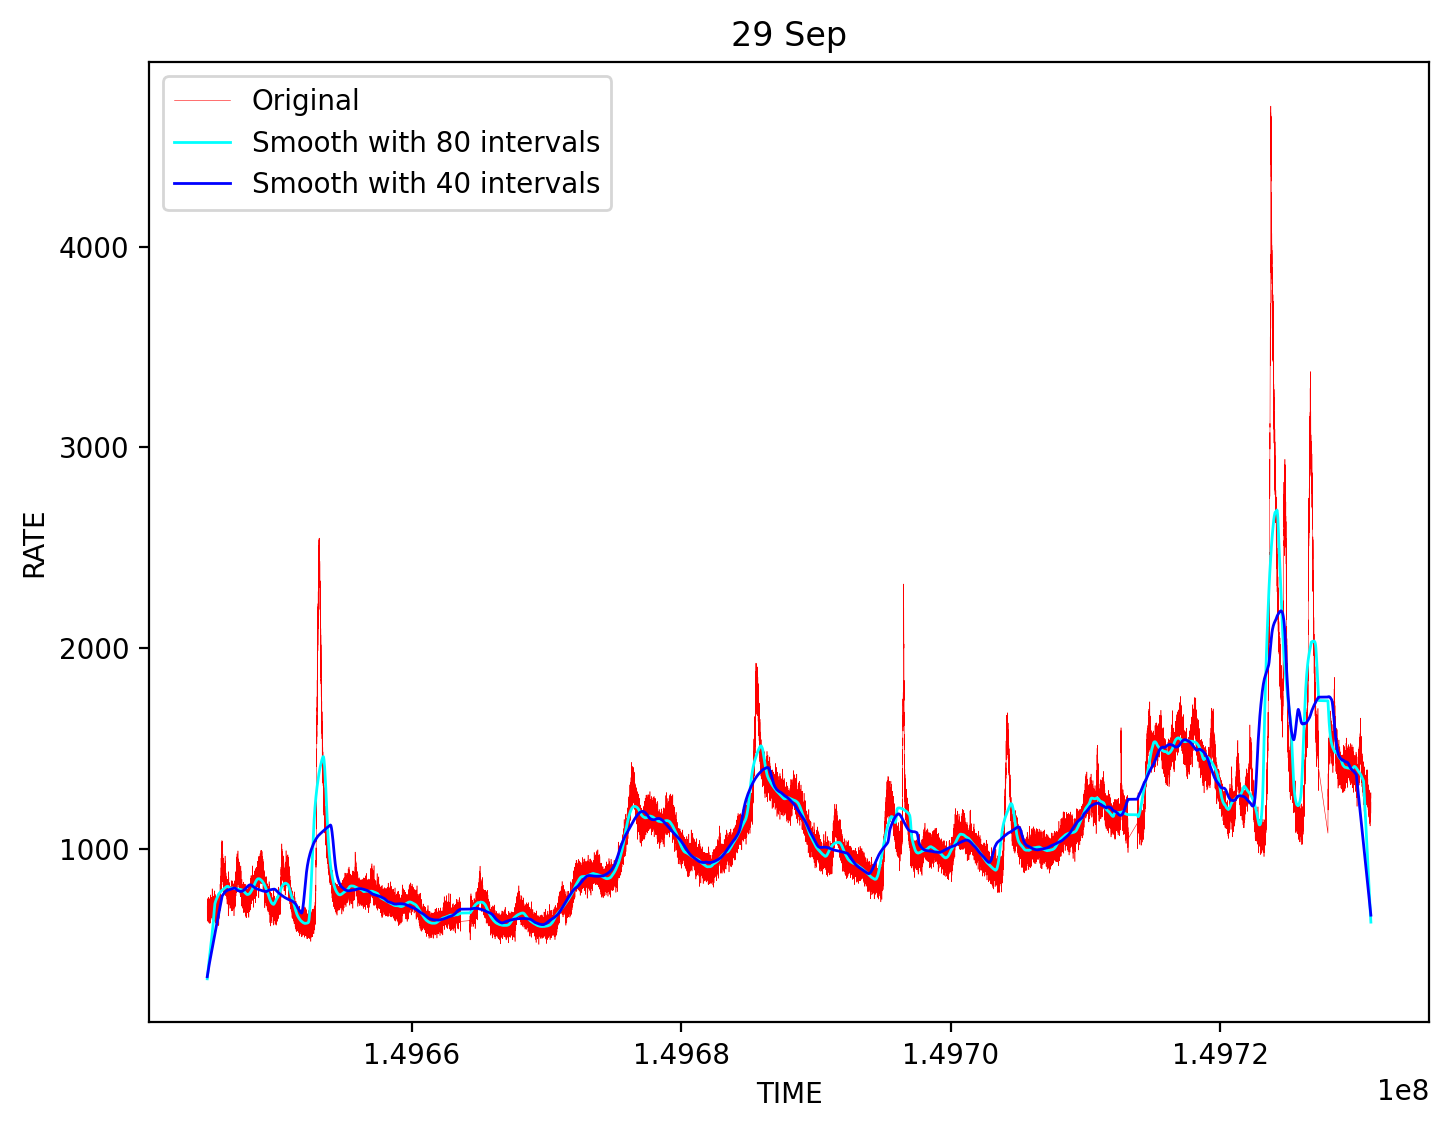

In [66]:
for i in range(5):
    fig = plt.figure(dpi=200)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.plot(data[i]['TIME'], data[i]['RATE'], 'r', linewidth=0.2)
    ax.plot(data[i]['TIME'], smooth_lightcurves_80[i], 'aqua', linewidth=1)
    ax.plot(data[i]['TIME'], smooth_lightcurves_40[i], 'b', linewidth=1)
    ax.set_title(dates[i])
    ax.set_xlabel('TIME')
    ax.set_ylabel('RATE')
    ax.legend(['Original', 'Smooth with 80 intervals', 'Smooth with 40 intervals'])

## 2) Binning

In [255]:
def rebin(bin_count, time, count):
    time_vals = np.array(np.array_split(np.sort(time), bin_count), dtype=object)
    count_vals = np.array(np.array_split(count, bin_count), dtype=object)
    time_vals = np.round(np.array([np.sum(i) for i in time_vals]), 0)
    count_vals = np.round(np.array([np.sum(i) for i in count_vals]), 0)
    return np.sort(time_vals), count_vals

In [256]:
a = np.array(np.array_split(np.arange(10), 3), dtype=object)

In [257]:
def myadd(arr):
    return np.sum(arr)
mysum = np.vectorize(myadd)
a, mysum(a)

(array([array([0, 1, 2, 3]), array([4, 5, 6]), array([7, 8, 9])],
       dtype=object),
 array([ 6, 15, 24]))

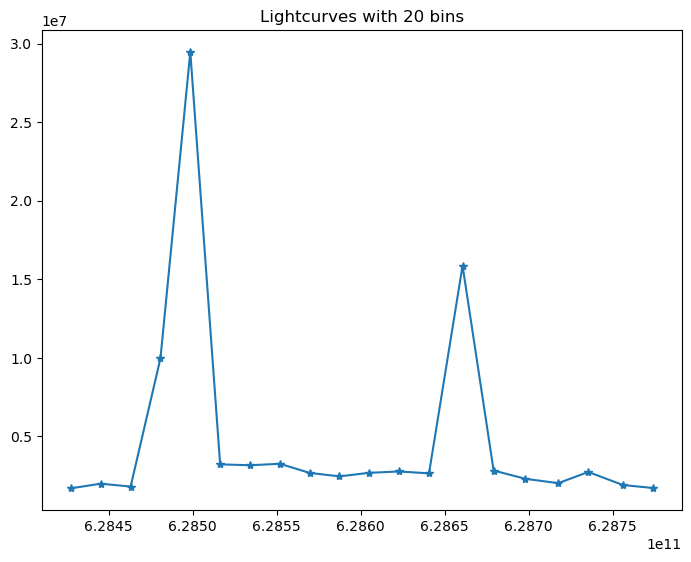

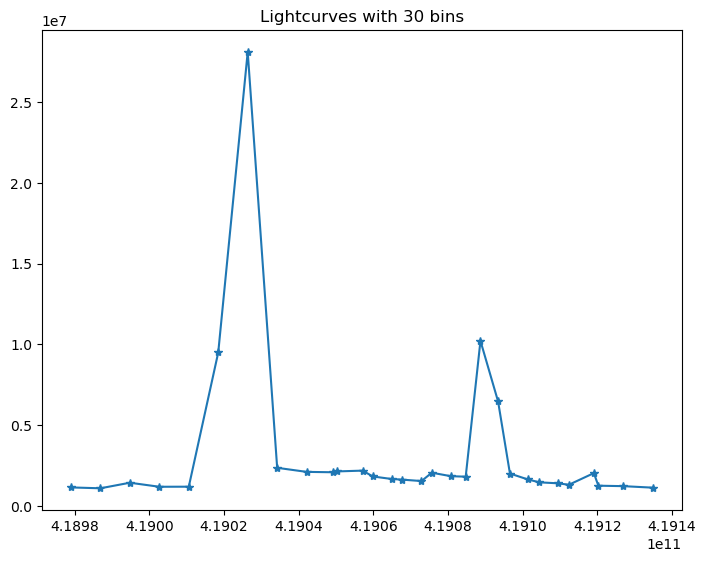

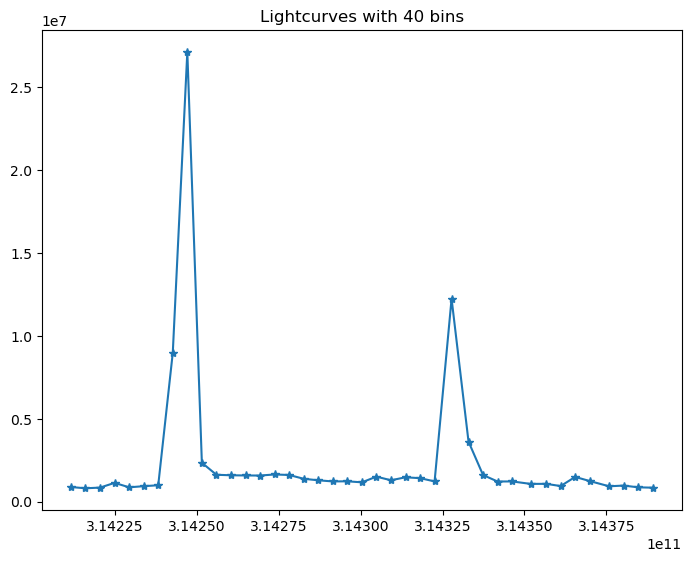

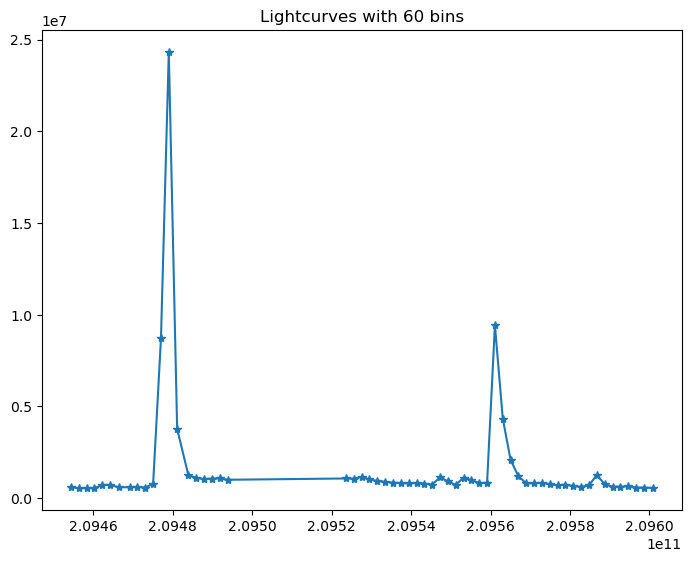

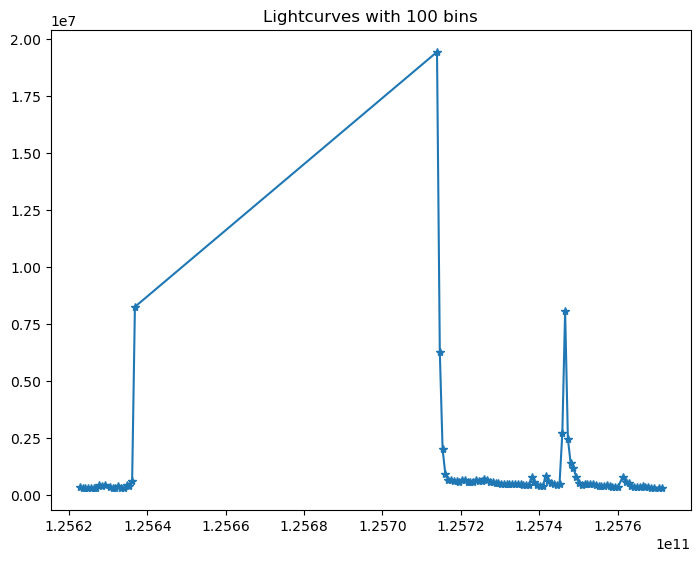

In [258]:
bins = [20, 30, 40, 60, 100]
for bin in bins:
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    time, count = rebin(bin, data[0]['TIME'], data[0]['RATE'])
    ax.plot(time, count, '*-')
    ax.set_title('Lightcurves with ' + str(bin) + ' bins')